# Upper Confidence Bounds - UCB1

UCB1 algorithm, unlike its siblings, makes a couple of assumptions that you may need to be cautious about.

Foremost of these is the assumption that the maximum possible reward has value 1. If that’s not true in your setting, you need to rescale all of your rewards to lie between 0 and 1 before using the UCB1 algorithm presented below.

In [23]:
%matplotlib inline

import math
import random

import pandas as pd
from matplotlib import pyplot as plt

In [2]:
def ind_max(x):
    m = max(x)
    return x.index(m)

In [3]:
class UCB1(): 
    
    def __init__(self, counts, values):
        self.counts = counts
        self.values = values
        return
    
    def initialize(self, n_arms):
        self.counts = [0 for col in range(n_arms)]
        self.values = [0.0 for col in range(n_arms)]
        return
    
    def select_arm(self):
        n_arms = len(self.counts)
        for arm in range(n_arms):
            if self.counts[arm] == 0:
                return arm
        
        ucb_values = [0.0 for arm in range(n_arms)]
        total_counts = sum(self.counts)
        
        for arm in range(n_arms):
            nr = 2 * math.log(total_counts)
            dr = float(self.counts[arm])
            
            fr = nr/dr
            bonus = math.sqrt(fr)
            ucb_values[arm] = self.values[arm] + bonus
        
        return ind_max(ucb_values)
    
    def update(self, chosen_arm, reward):
        self.counts[chosen_arm] += 1
        n = self.counts[chosen_arm]
        
        value = self.values[chosen_arm]
        new_value = ((n - 1) / float(n)) * value + (1 / float(n)) * reward
        self.values[chosen_arm] = new_value
        return

In [4]:
class BernoulliArm():
    def __init__(self, p):
        self.p = p
    def draw(self):
        if random.random() > self.p:
            return 0.0
        else:
            return 1.0

In [24]:
def test_algorithm(algo, arms, num_sims, horizon):
    chosen_arms = [0.0 for i in range(num_sims * horizon)]
    rewards = [0.0 for i in range(num_sims * horizon)]
    cumulative_rewards = [0.0 for i in range(num_sims * horizon)]
    sim_nums = [0.0 for i in range(num_sims * horizon)]
    times = [0.0 for i in range(num_sims * horizon)]
    for sim in range(num_sims):
        sim = sim + 1
        algo.initialize(len(arms))
        for t in range(horizon):
            t = t + 1
            index = (sim - 1) * horizon + t - 1
            sim_nums[index] = sim
            times[index] = t
            chosen_arm = algo.select_arm()
            chosen_arms[index] = chosen_arm
            reward = arms[chosen_arms[index]].draw()
            rewards[index] = reward
            if t == 1:
                cumulative_rewards[index] = reward
            else:
                cumulative_rewards[index] = cumulative_rewards[index - 1] + reward
            algo.update(chosen_arm, reward)
    return [sim_nums, times, chosen_arms, rewards, cumulative_rewards]

In [25]:
def simulate_tests(means=[0.1, 0.1, 0.1, 0.1, 0.9], epsilons=[0.1], 
                   filename="ucb1_results.tsv",
                   num_sims= 5000, horizon=250):
    n_arms = len(means)
    random.shuffle(means)
    arms = [BernoulliArm(mu) for mu in means]
    best_arm = ind_max(means)
    print("Best arm is " + str(ind_max(means)))

    f = open(filename, "w")

    for epsilon in epsilons:
        algo = UCB1([], [])
        algo.initialize(n_arms)
        results = test_algorithm(algo, arms, num_sims, horizon)
        for i in range(len(results[0])):
            f.write(str(epsilon) + "\t")
            f.write("\t".join([str(results[j][i]) for j in range(len(results))]) + "\n")
    f.close()
    
    df = pd.read_csv(filename, sep='\t', header=None, 
                     names=["Epsilon", "Sim", "T", "ChosenArm", "Reward", "CumulativeReward"])
    
    return df, best_arm

In [26]:
def plot_prob_best_arm(df, best_arm):
    df = df.copy()
    fig, ax = plt.subplots(figsize=(15,8))
    xseries = df[df['ChosenArm'].eq(best_arm)].groupby(['T', 'Epsilon'])['ChosenArm'].count().to_frame()
    xseries = xseries['ChosenArm'].apply(lambda x: x/5000).unstack().plot(ax=ax)
    xseries.set_ylabel(f"Probability of selecting best arm ({best_arm})")
    xseries.set_xlabel("Turn")

In [27]:
def plot_avg_reward(df):
    df = df.copy()
    fig, ax = plt.subplots(figsize=(15,8))
    xseries = df.groupby(['T', 'Epsilon'])['Reward'].mean().unstack().plot(ax=ax)
    xseries.set_ylabel("Average reward")
    xseries.set_xlabel("Turn")

In [28]:
def plot_cumulative_reward(df):
    df = df.copy()
    fig, ax = plt.subplots(figsize=(15,8))
    xseries = df.groupby(['T', 'Epsilon'])['CumulativeReward'].mean().unstack().plot(ax=ax)
    xseries.set_ylabel("Cumulative reward")
    xseries.set_xlabel("Turn")

Best arm is 3


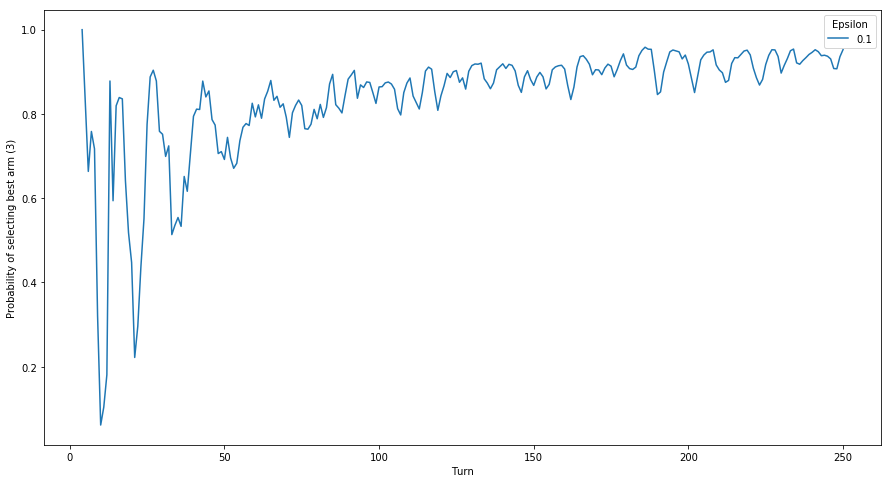

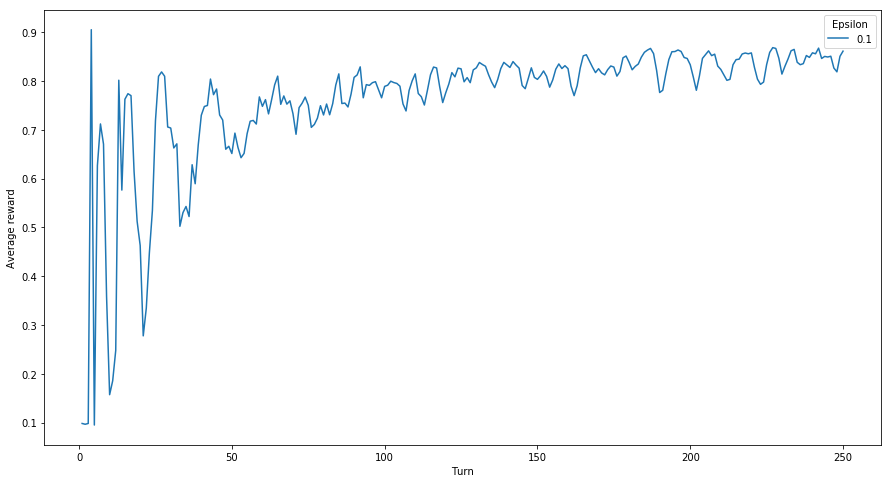

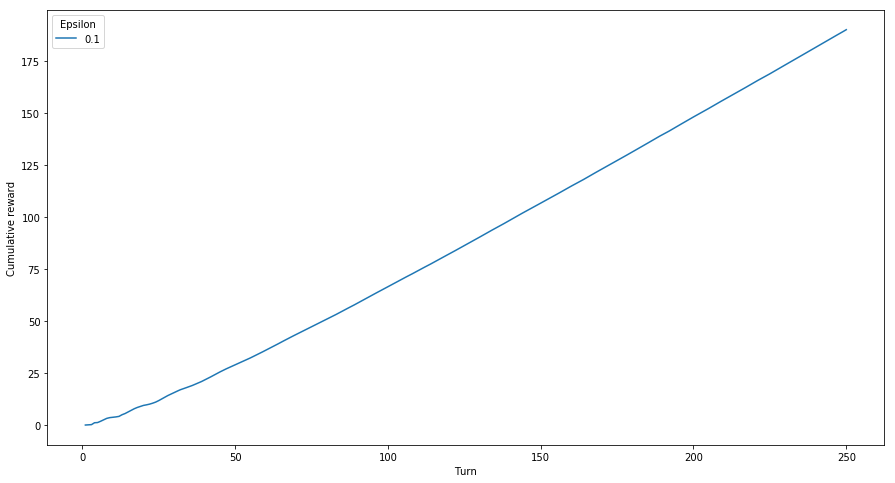

In [29]:
df, best_arm = simulate_tests()

plot_prob_best_arm(df, best_arm)
plot_avg_reward(df)
plot_cumulative_reward(df)